In [1]:
%%html
<link rel="stylesheet" type="text/css" href="css/rise.css" />

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['lines.markeredgecolor'] = 'w'
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['figure.figsize'] = [8, 6]

# Support Vector Machine (SVM) classifier

### Learning goals - *SVM classifier*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will...</div> | `e.g.` |

A decision boundary used for binary classification.

![](images/svm-vline.webp)

Optimal boundary maximizes the distance between each class (margin).

![](images/svm-dline.webp)

![](images/svm-margin-support-vectors.png)

Multinomial one-vs-one classification with SVM.

![](images/svm-2vs3-classes.png)

Expression levels of 77 proteins measured in the cerebral cortex of 8 classes of control and Down syndrome (Ts65Dn) mice exposed to context fear conditioning.

https://www.kaggle.com/ruslankl/mice-protein-expression

In [24]:
import pandas as pd
df = pd.read_csv('data/Data_Cortex_Nuclear.csv')
df

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s


Goal is to use protein expression levels to classify mice. Each mouse in the dataset belongs to one of the following eight classes:

1. c-CS-s: control mice,  stimulated to learn,      injected with saline
2. c-CS-m: control mice,  stimulated to learn,      injected with memantine
3. c-SC-s: control mice,  not stimulated to learn,  injected with saline
4. c-SC-m: control mice,  not stimulated to learn,  injected with memantine
5. t-CS-s: trisomy mice,  stimulated to learn,      injected with saline
6. t-CS-m: trisomy mice,  stimulated to learn,      injected with memantine
7. t-SC-s: trisomy mice,  not stimulated to learn,  injected with saline
8. t-SC-m: trisomy mice,  not stimulated to learn,  injected with memantine

which are combinations of:

* Control vs. down syndrome.
* Did or did not recieve behavioral conditioning.
* Saline vs. memantine injection.

First, throw out features and data points with missing measurements.

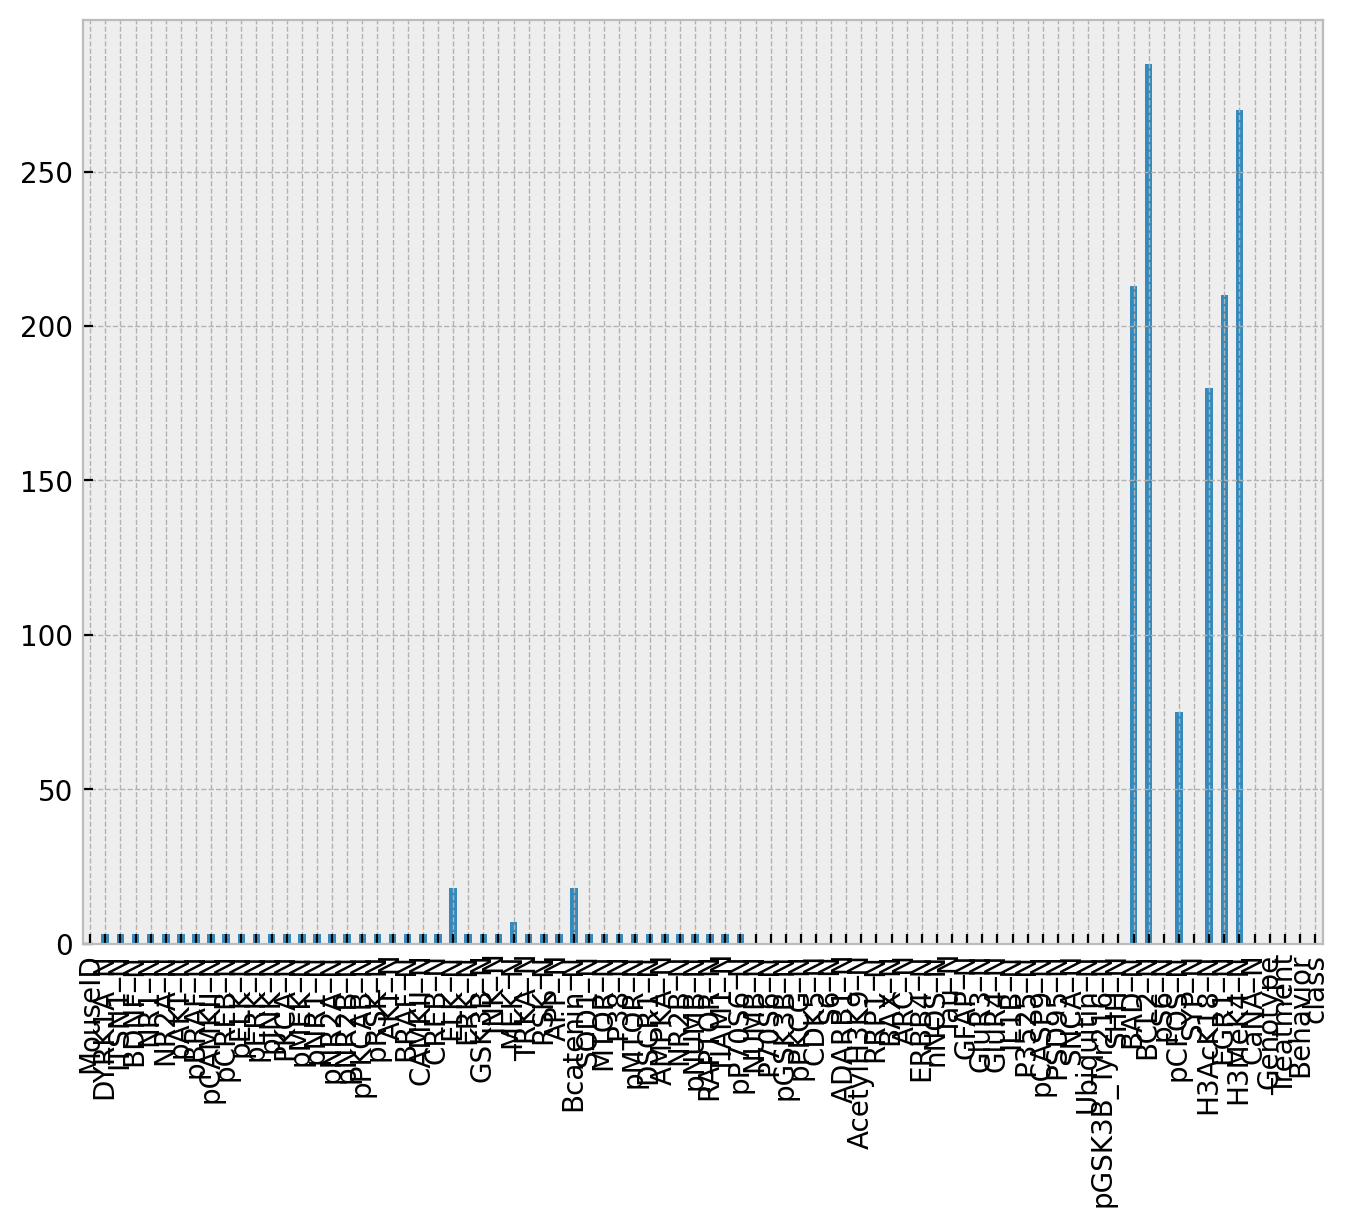

In [25]:
df.isnull().sum().plot.bar();

In [26]:
miss_too_many = df.isnull().sum() > 10

miss_too_many

MouseID      False
DYRK1A_N     False
ITSN1_N      False
BDNF_N       False
NR1_N        False
             ...  
CaNA_N       False
Genotype     False
Treatment    False
Behavior     False
class        False
Length: 82, dtype: bool

In [27]:
df2 = df.loc[:, ~miss_too_many]

df.shape, df2.shape

((1080, 82), (1080, 74))

In [28]:
# discard mice with missing measurements
df2 = df2.dropna()

df2.shape

(1073, 74)

The dataset we will use for building a classsification model.

In [29]:
df2

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,SYP_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,1.044979,0.831557,0.188852,0.106305,0.427099,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,1.009883,0.849270,0.200404,0.106592,0.441581,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.996848,0.846709,0.193685,0.108303,0.435777,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.990225,0.833277,0.192112,0.103184,0.391691,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.997775,0.878668,0.205604,0.104784,0.434154,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,1.261651,0.962942,0.275547,0.115806,0.374088,1.364823,Ts65Dn,Saline,S/C,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,1.254872,0.983690,0.283207,0.113614,0.375259,1.364478,Ts65Dn,Saline,S/C,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,1.242248,0.976609,0.290843,0.118948,0.422121,1.430825,Ts65Dn,Saline,S/C,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,1.301071,0.989286,0.306701,0.125295,0.397676,1.404031,Ts65Dn,Saline,S/C,t-SC-s


Use an SVM classifier to predict mouse class based on protein expression in cortex.

In [34]:
from sklearn.utils import shuffle

X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()  # just protein expression levels
y = df2['class'].to_numpy()

# shuffle data
X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69),
 (1073,),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

In [35]:
from sklearn.svm import SVC

model = SVC(kernel='linear')

Get cross validated predictions.

In [36]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, X, y, cv=10)

Plot a confusion matrix.

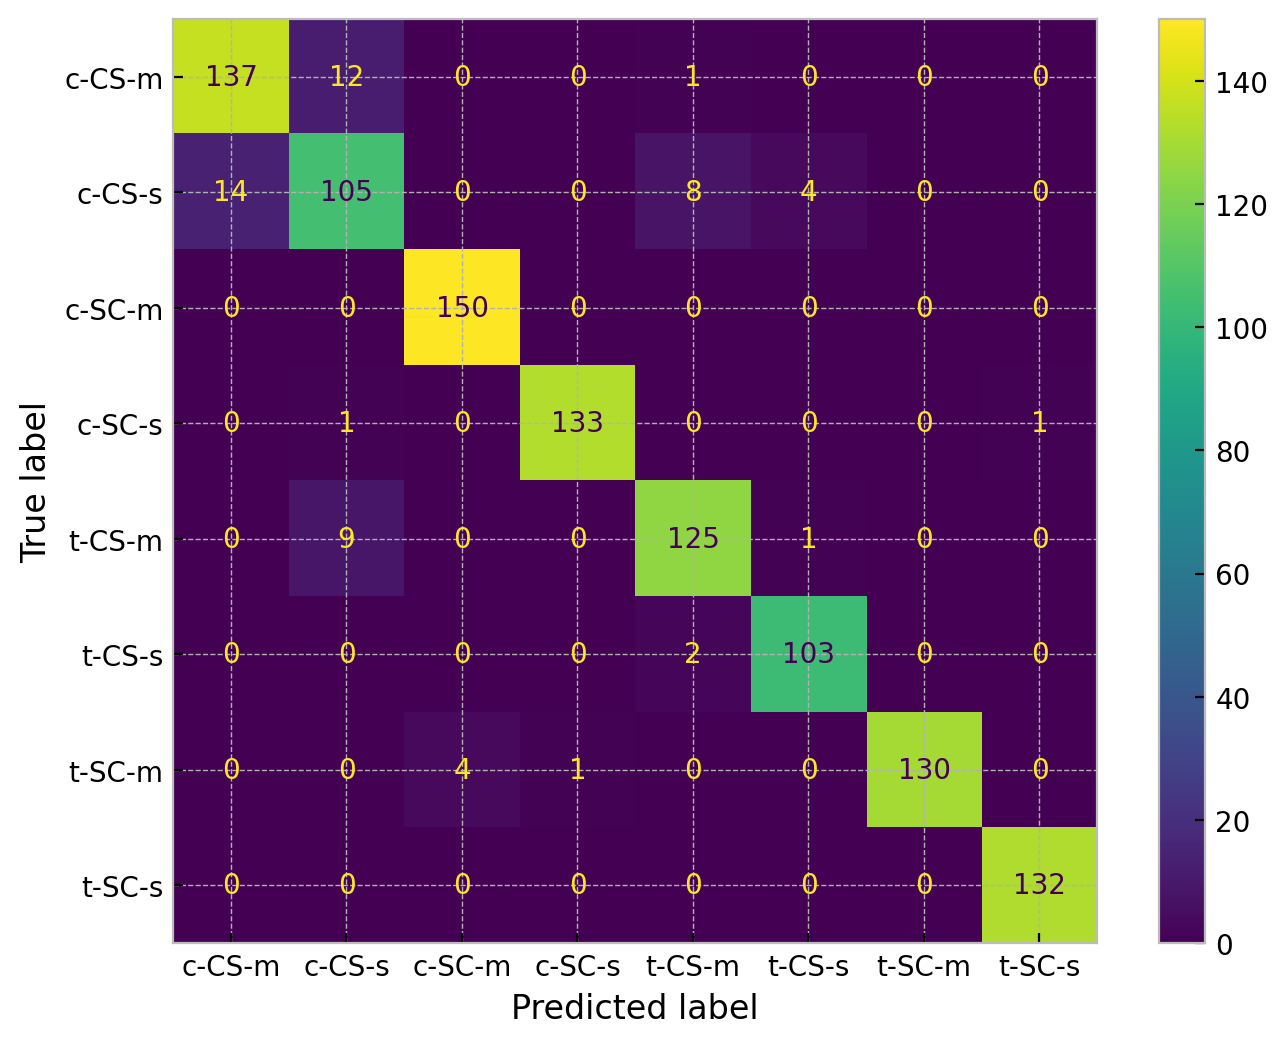

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot();

Results are similar to the logistic regression model from the last lecture.

**Soft margin** allows for misclassifications in the training set. The penalty for missclassifications is scaled by a hyperparameter `C` which sets a compromise between missclassifications and maximizing the margin.

* **left**: Larger penalty for missclassifications.
* **right**: Smaller penalty for missclassifications.

![](images/svm-largeC-vs-smallC.png)

# Exercise

Determine the optimal value of the penalty `C` for predicting a mouse's class based on its cortical protein expression profile. 

In [ ]:
from sklearn.model_selection import GridSearchCV

# SVM linear classifier
model = ...

# try these values for the penalty C
params = {'C': np.logspace(-1, 2, 30)}

# grid search cross validation to find best C
gridsearch = GridSearchCV(...)
gridsearch.fit(X, y)

best_C = gridsearch.best_params_['C']
best_model = gridsearch.best_estimator_
best_model

# Exercise Key

Determine the optimal value of the penalty `C` for predicting a mouse's class based on its cortical protein expression profile. 

In [39]:
from sklearn.model_selection import GridSearchCV

# SVM linear classifier
model = SVC(kernel='linear')

# try these values for the penalty C
params = {'C': np.logspace(-1, 2, 30)}

# grid search cross validation to find best C
gridsearch = GridSearchCV(model, params, cv=10, scoring='accuracy')
gridsearch.fit(X, y)

best_C = gridsearch.best_params_['C']
best_model = gridsearch.best_estimator_
best_model

SVC(C=23.95026619987486, kernel='linear')

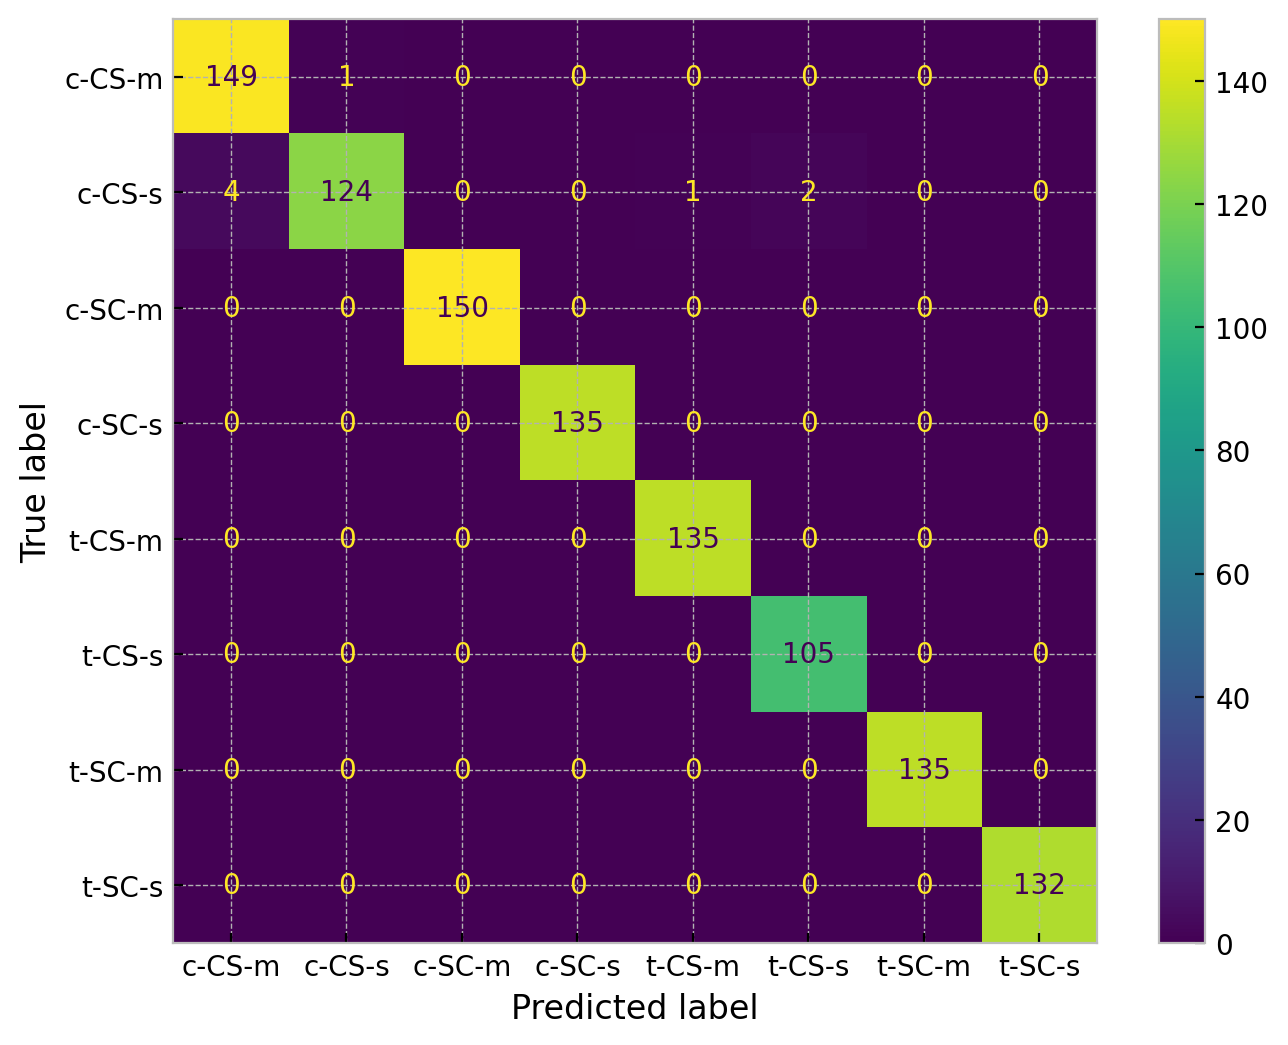

In [40]:
y_pred = cross_val_predict(best_model, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot();

At least as accurate as our logistic regression classifier with tuned regularization hyperparameter from last lecture.

And the fit was way faster than for the logistic regression model!

SVM can incorporate nonlinear decision boundaries. In `sklearn.svm.SVC` this is set via the `kernel` parameter.

![](images/svm-linear-vs-nonlinear.png)

SVM polynomial kernel.

![](images/svm-poly-mapping.webp)

SVM nonlinar boundary.

![](images/svm-nonlinear-mapping.png)

Contour boundaries.

![](images/svm-kernel.jpeg)

A decent video explaining the basics of SVM classfiers.

https://www.youtube.com/watch?v=efR1C6CvhmE&t=0s

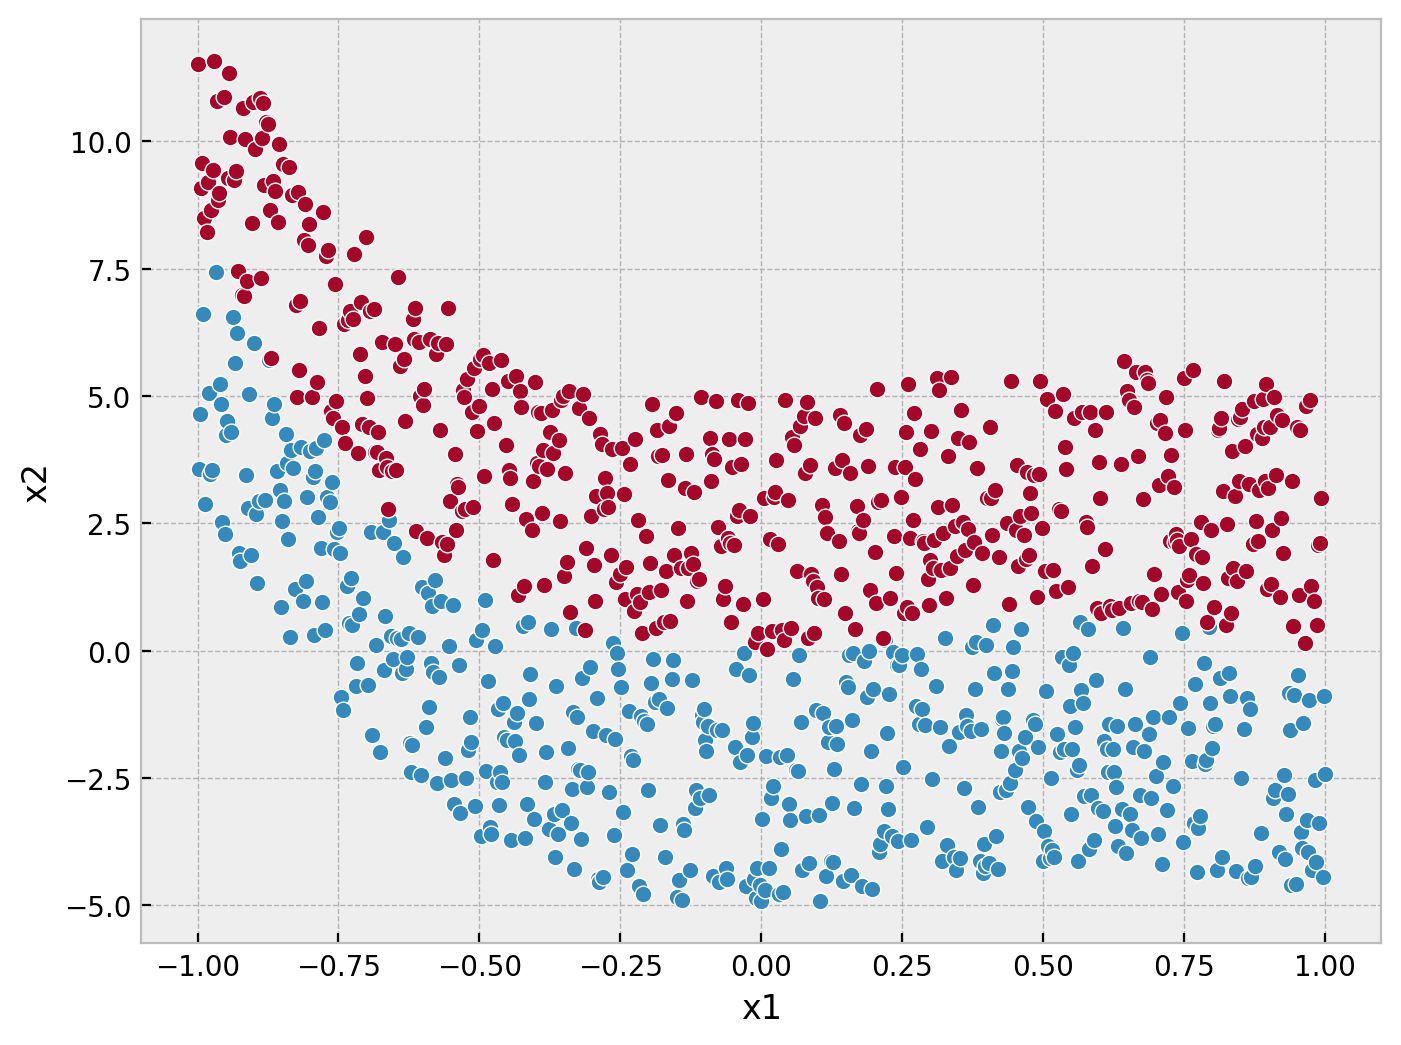

In [47]:
np.random.seed(80)
x1 = np.linspace(-1, 1, 1000)
a, b, c = np.random.uniform(-10, 10, 3)
m = a * x1 + b * x1**2 + c * x1**3
x2 = m + np.random.uniform(0, 5, x1.shape) * np.random.choice([-1, 1], x1.shape)
y = np.zeros(len(x1))
y[x2 > m] = 1

plt.plot(x1[y == 0], x2[y == 0], 'o')
plt.plot(x1[y == 1], x2[y == 1], 'o')
plt.xlabel('x1')
plt.ylabel('x2');

In [48]:
X = np.vstack([x1, x2]).T

X.shape, y.shape

((1000, 2), (1000,))

Radial Basis Function (RBF) kernel ~ Gaussian kernel

In [49]:
from sklearn.model_selection import GridSearchCV

model = SVC(kernel='rbf')
params = {'C': np.logspace(-1, 3, 40)}

gridsearch = GridSearchCV(model, params, cv=10, scoring='accuracy')
gridsearch.fit(X, y)

best_model = gridsearch.best_estimator_
best_model

SVC(C=388.81551803080856)

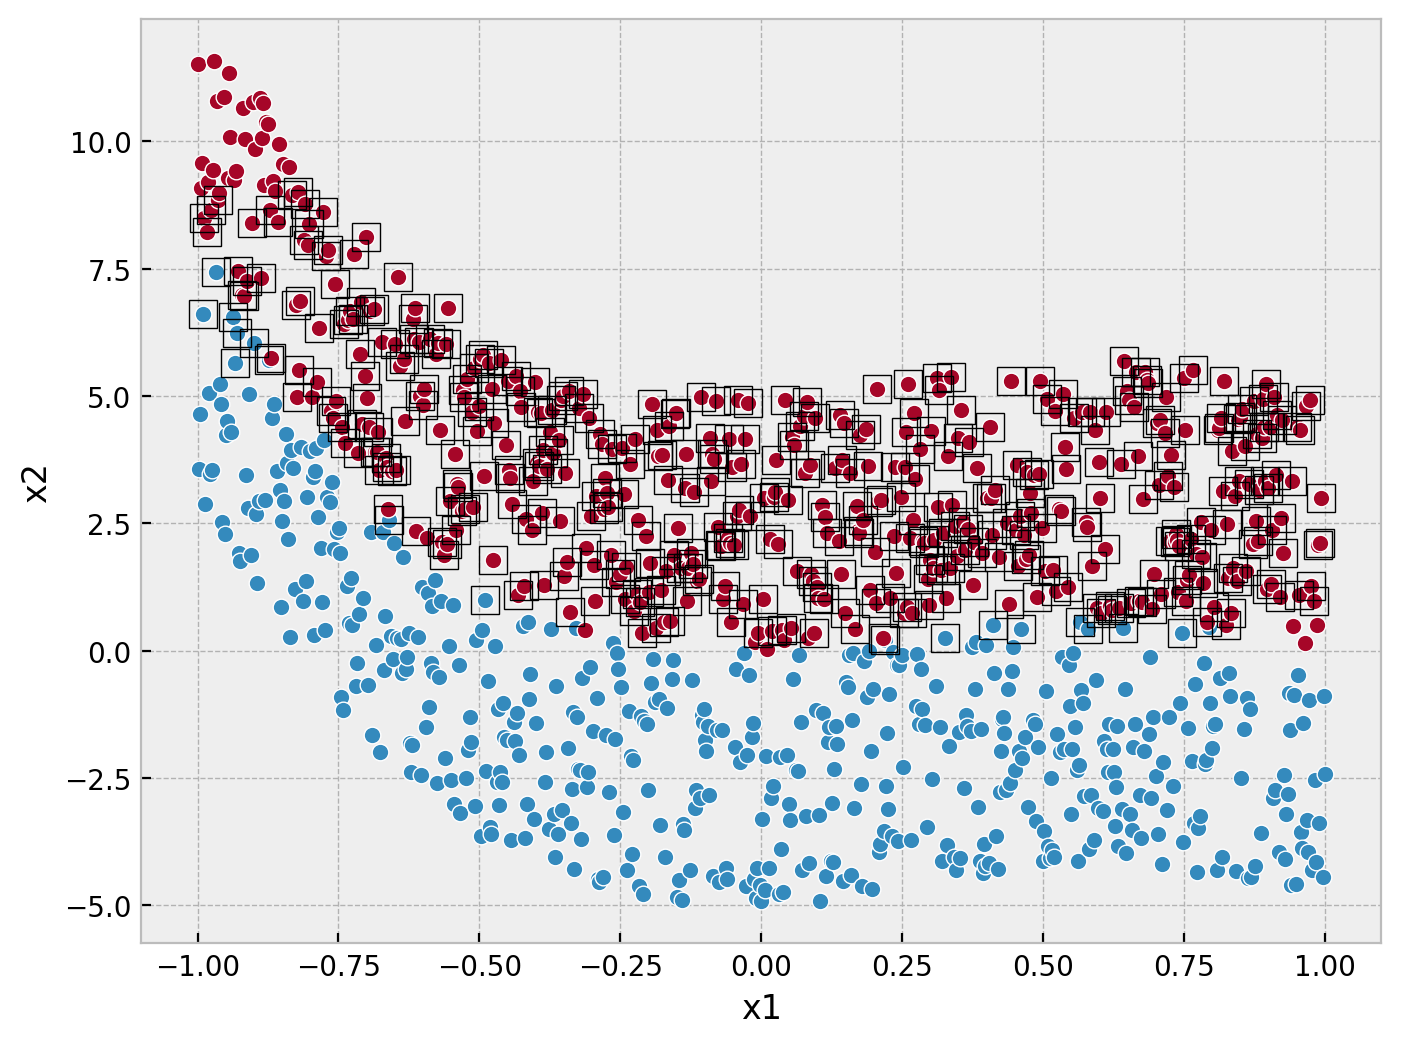

In [51]:
y_pred = cross_val_predict(best_model, X, y, cv=10)

plt.plot(x1[y == 0], x2[y == 0], 'o')
plt.plot(x1[y == 1], x2[y == 1], 'o')
plt.plot(x1[y_pred == 1], x2[y_pred == 1], 's', ms=10, mfc='none', mec='k')
plt.xlabel('x1')
plt.ylabel('x2');

# Exercise

Use an SVM classifier with a radial basis function kernel to predict a mouse's class based on its cortical protein expression profile.

In [53]:
X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()  # just protein expression levels
y = df2['class'].to_numpy()

X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69),
 (1073,),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

In [ ]:
model = ...
params = {'C': np.logspace(-1, 3, 40)}

gridsearch = ...
...

best_model = gridsearch.best_estimator_
best_model

# Exercise Key

Use an SVM classifier with a radial basis function kernel to predict a mouse's class based on its cortical protein expression profile.

In [54]:
X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()  # just protein expression levels
y = df2['class'].to_numpy()

X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69),
 (1073,),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

In [55]:
model = SVC(kernel='rbf')
params = {'C': np.logspace(-1, 3, 40)}

gridsearch = GridSearchCV(model, params, cv=10, scoring='accuracy')
gridsearch.fit(X, y)

best_model = gridsearch.best_estimator_
best_model

SVC(C=94.26684551178855)

Let's use a confusion matrix to visualize how well the SVM model with radial basis function did.

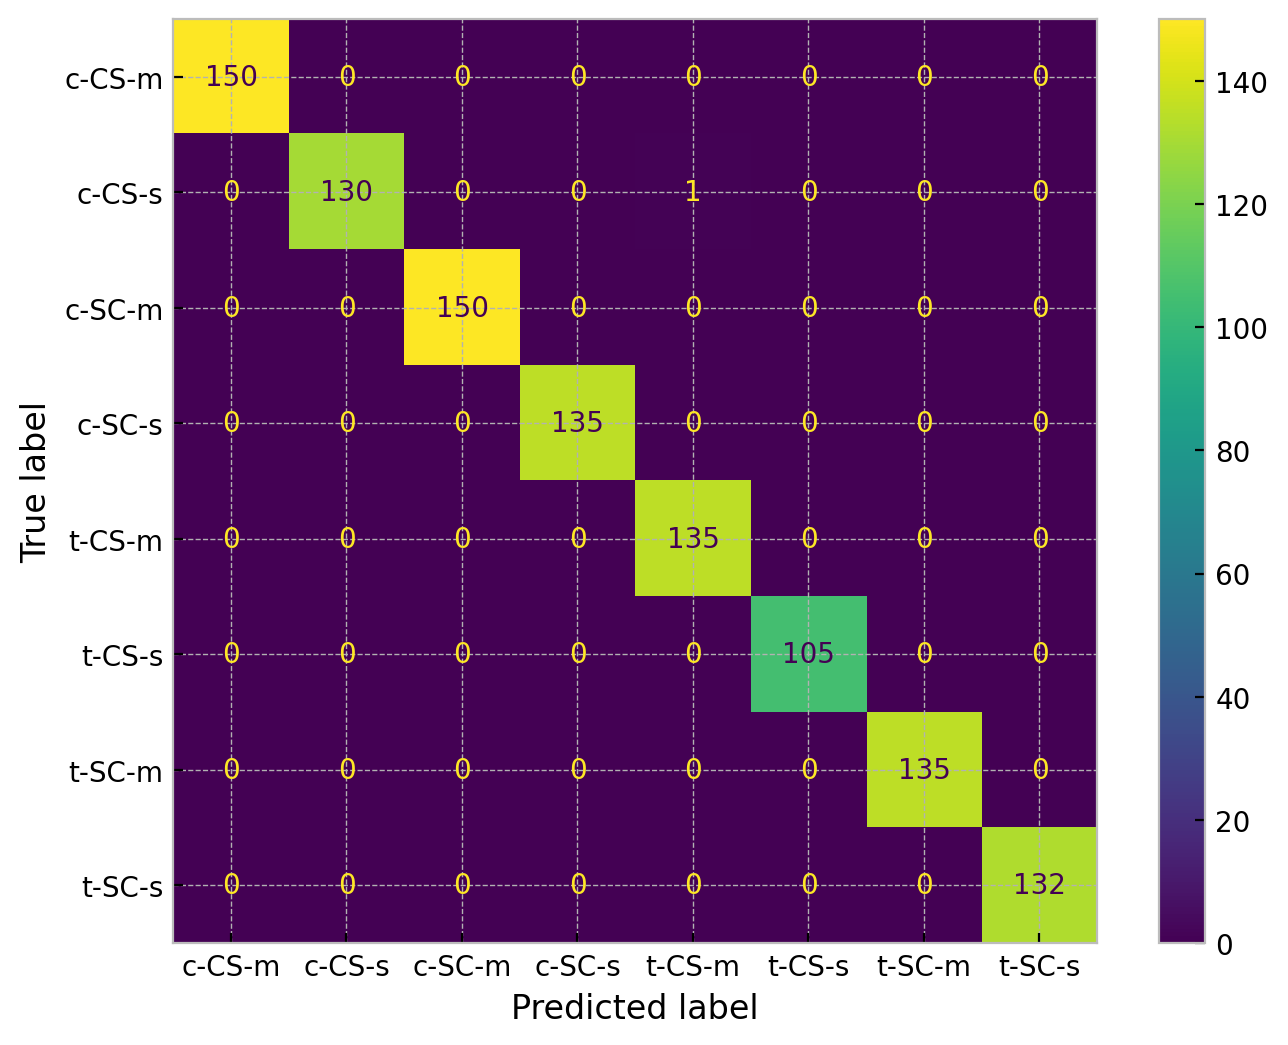

In [56]:
y_pred = cross_val_predict(best_model, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot();

Just a reminder, that at the end of the day once you have selected a model, you should fit it to all of your data.

In [57]:
best_model.fit(X, y)

SVC(C=94.26684551178855)

Now you whould distribute this model to others or apply it to make predictions about new data.

# Bagging

### e.g., Random forest classifier

### Learning goals - *Random forest classifier*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will...</div> | `e.g.` |

# Decision Tree

![](images/decision-tree.png)

A decision tree can fit data with a highly irregular mapping between predictors and classes.

![](images/tree-splits.png)

Use a decision tree to predict mouse genotype based on protein experssion profile.

In [58]:
from sklearn.utils import shuffle

X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()
y = df2['Genotype'].to_numpy()

X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69), (1073,), array(['Control', 'Ts65Dn'], dtype=object))

In [59]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)

model.fit(X, y)

accuracy = model.score(X, y)
accuracy

1.0

But how accurate is the model on data it was not trained on?

In [60]:
from sklearn.model_selection import cross_val_score

accuracy = cross_val_score(model, X, y, cv=10)
accuracy.mean()

0.8973952924887506

A decision tree tends to overfit the data (i.e., is very sensative to the exact data it is trained on).

Tree depth influences underfitting vs. overfitting.

![](images/tree-split-iters.jpg)

See if you can do better by finding an optimal maximal tree depth.

In [64]:
model = DecisionTreeClassifier(random_state=0)
params = {'max_depth': np.arange(3, 20)}
grid = GridSearchCV(model, params, cv=10, scoring='accuracy')
grid.fit(X, y)

tuned_model = grid.best_estimator_
tuned_model

DecisionTreeClassifier(max_depth=9, random_state=0)

In [65]:
accuracy = cross_val_score(tuned_model, X, y, cv=10)
accuracy.mean()

0.897403946002077

In this case we haven't really improved much over the default of no maximum depth, although we can see that enforcing only a very shallow tree underfits the data.

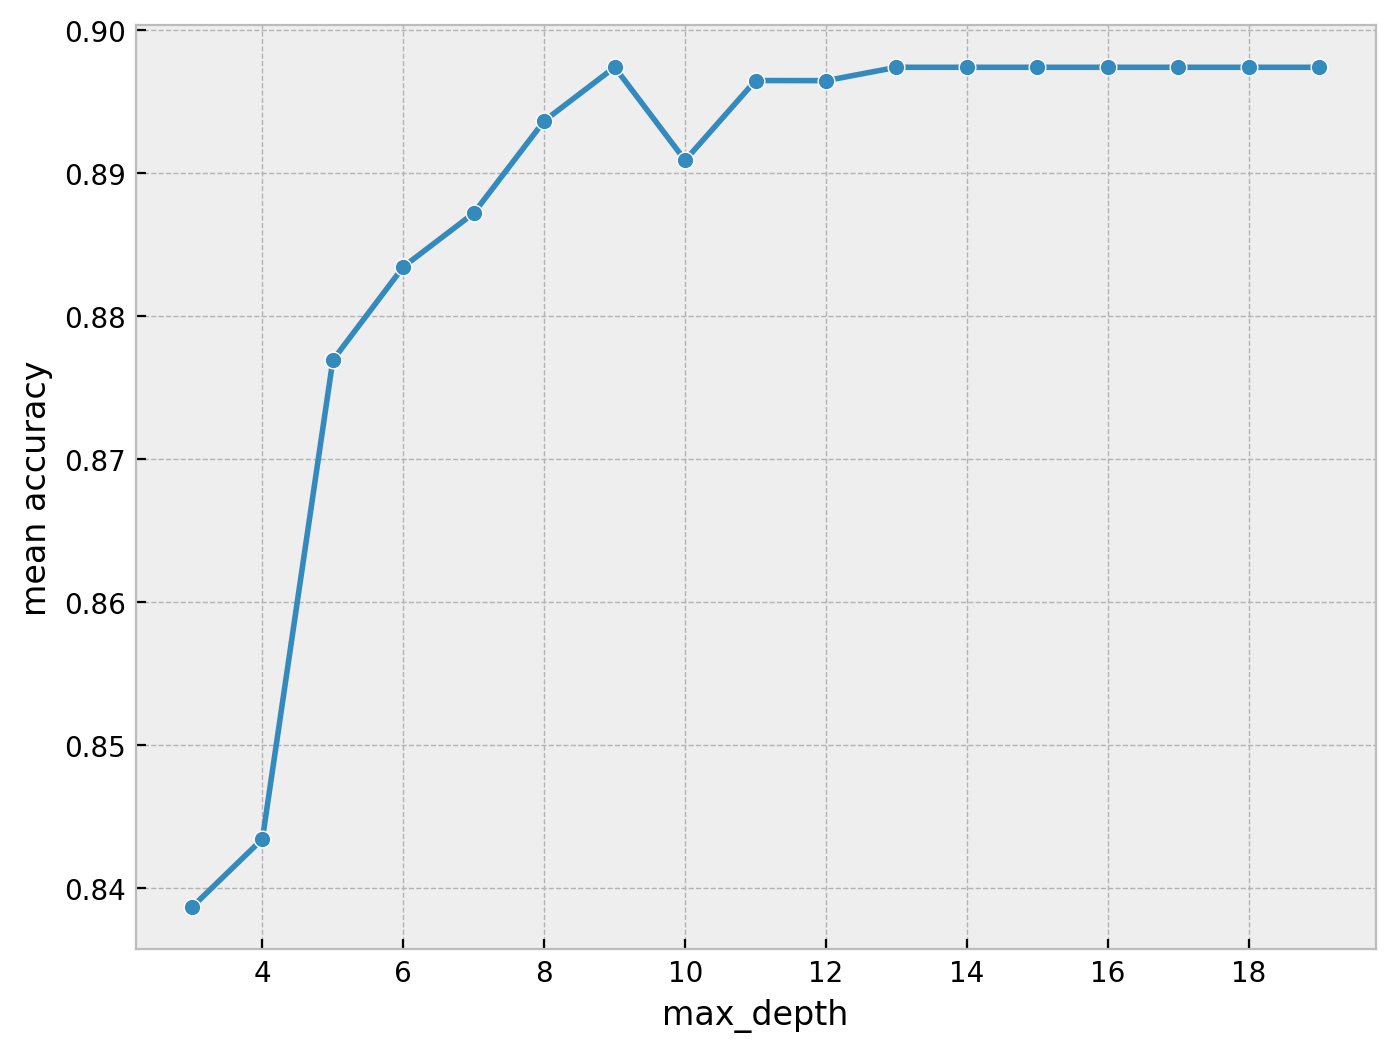

In [66]:
plt.plot(params['max_depth'], grid.cv_results_['mean_test_score'], 'o-')
plt.xlabel('max_depth')
plt.ylabel('mean accuracy');

But we still haven't avoided overfitting.

In [67]:
tuned_model.fit(X, y)

accuracy = tuned_model.score(X, y)
accuracy

0.9962721342031687

But since a tree depth of anything above about 10 was more or less equally as good, that means splitting the data based on only ~10 proteins is approximatley as good as splitting on all 69 proteins.

But which 10 proteins are the most important?

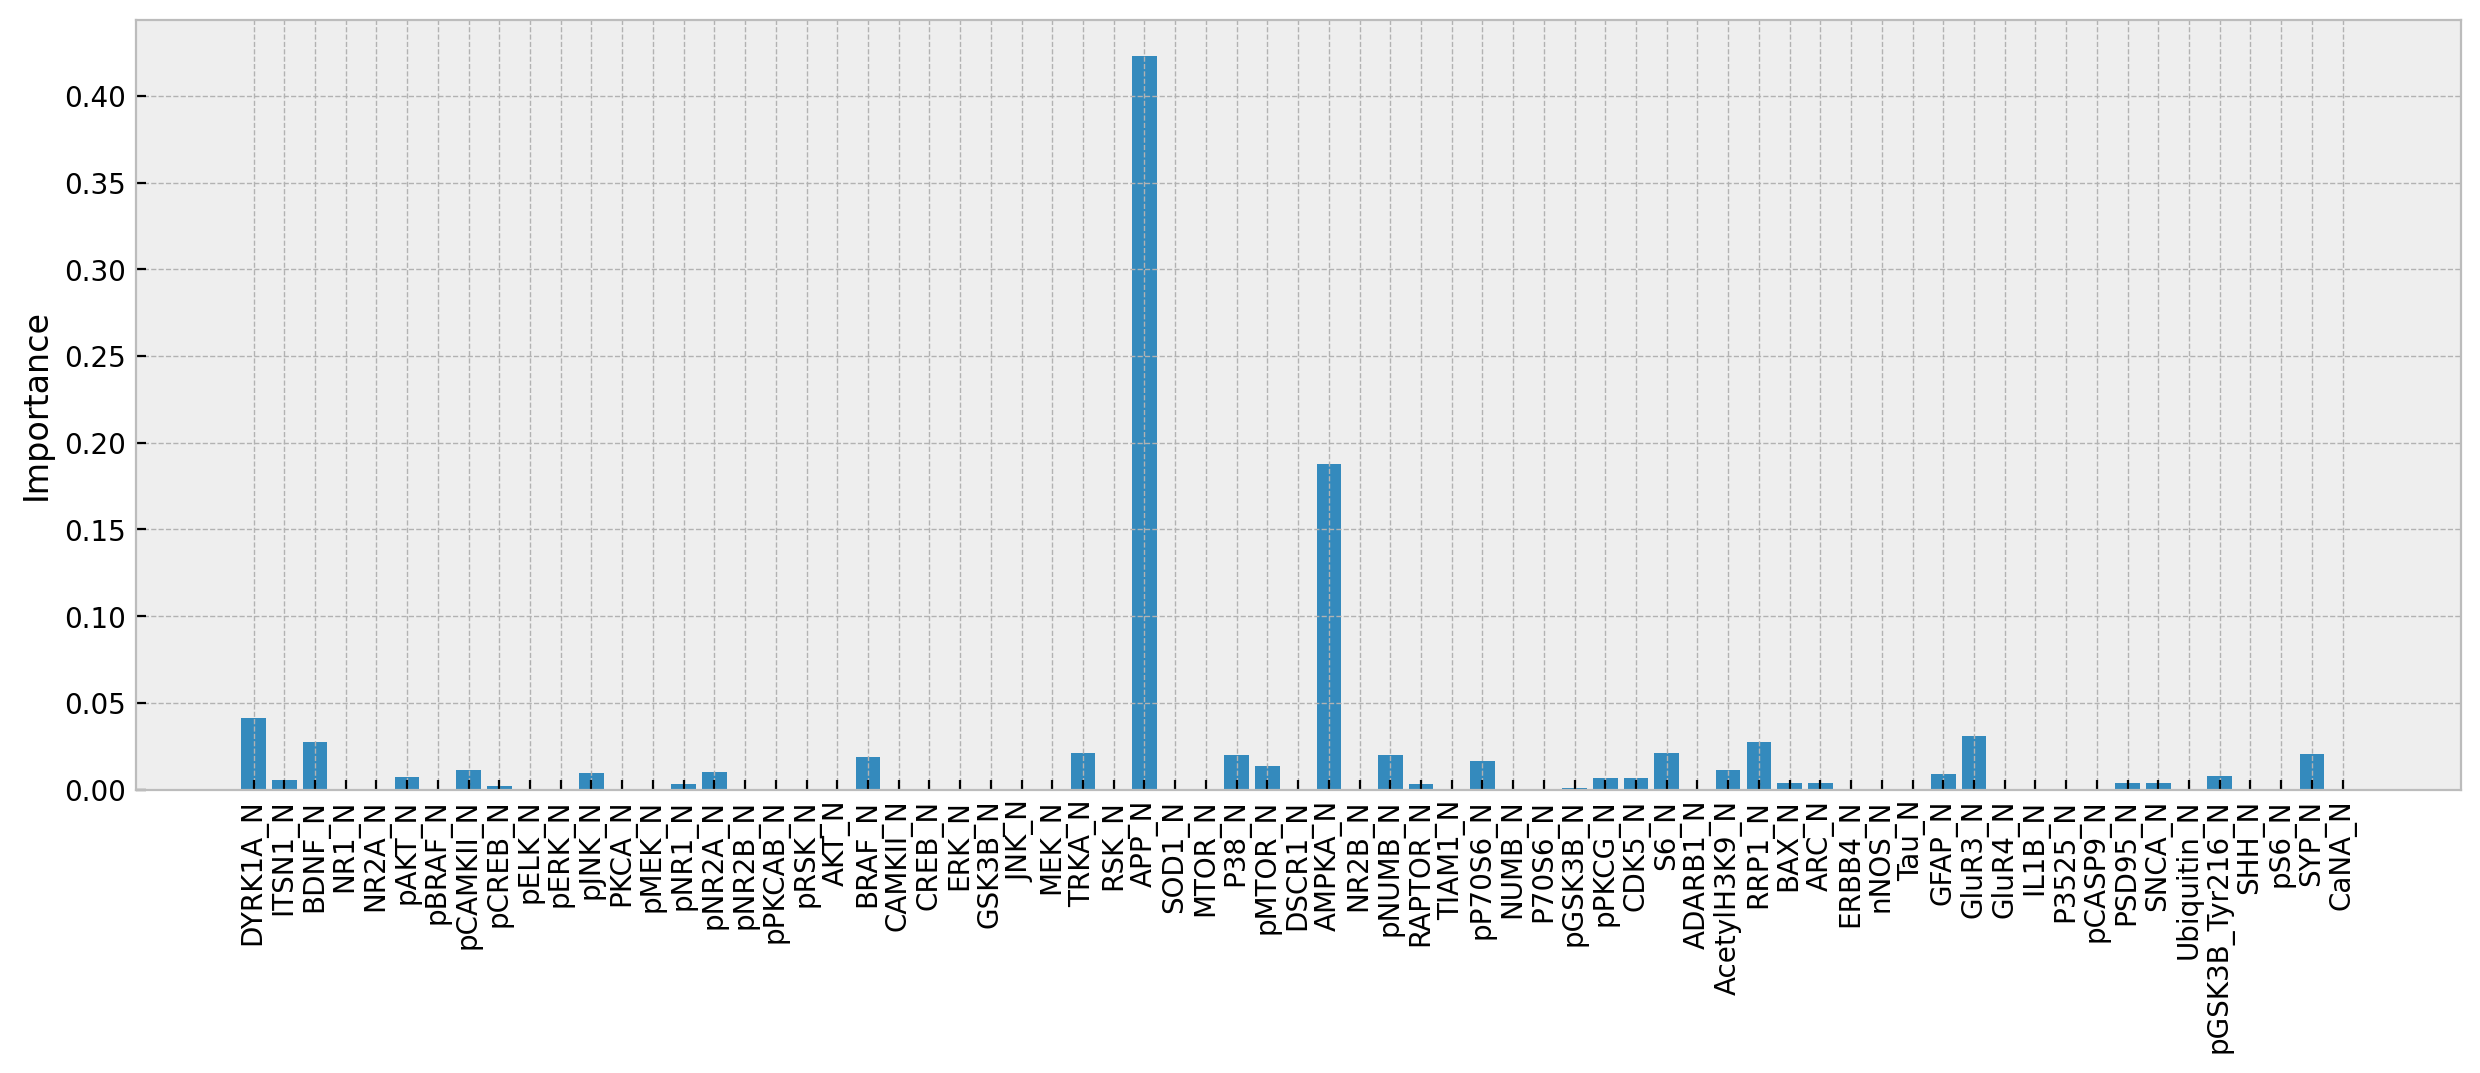

In [68]:
proteins = df2.loc[:,'DYRK1A_N':'CaNA_N'].columns

plt.figure(figsize=[15,5])
plt.bar(range(69), tuned_model.feature_importances_)
plt.xticks(range(69), proteins, rotation=90)
plt.ylabel('Importance');

Try using a decision tree to predict genotype based on only the 10 most important proteins.

In [69]:
sorted_ind = np.argsort(tuned_model.feature_importances_)

most_important_cols = sorted_ind[-10:]
most_important_cols

array([32, 67, 27, 46,  2, 49, 56,  0, 35, 29])

In [70]:
proteins[most_important_cols]

Index(['P38_N', 'SYP_N', 'TRKA_N', 'S6_N', 'BDNF_N', 'RRP1_N', 'GluR3_N',
       'DYRK1A_N', 'AMPKA_N', 'APP_N'],
      dtype='object')

In [71]:
X10 = X[:,most_important_cols]

tuned_model.fit(X10, y)

accuracy = tuned_model.score(X10, y)
accuracy

0.9953401677539608

In [72]:
accuracy = cross_val_score(tuned_model, X10, y, cv=10)
accuracy.mean()

0.9048546209761164

So we have identified 10 proteins that may be the most important for predicting genotype, but our decision tree model is overfitting the training data and performing more poorly on the validation data on which it was not trained.

This tends to be an issue with decision trees.

## Ensemble models

Instead of a single model, you use an average or majority vote amongst an esnemble of many models as your model prediction.

Each model in the ensemble must differ slightly (otherwise what's the point?). This could be because the models themselves are all a bit different and/or each model is trained on slightly different data.

## Random Forest

Create an **ensemble** of many decision trees, where for each tree you...

1. Select a **random subset of features** from the whole set of features.
2. Select a random subset of data points (rows) from the whole dataset with replacement (e.g. a **bootstrapped dataset**).
3. Train the tree on the selected subset of features and bootstrapped data points.

### Bagging (Bootstrap Aggregation)

You then take the the class that is predicted by the most trees as the model prediction.

![](images/random-forest.png)

Image from https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725

# Question?

Can you think of a reason why a random forest could potentially outperform a single decision tree?

Use a random forest to predict mouse genotype based on protein experssion profile.

In [73]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)

accuracy = cross_val_score(model, X, y, cv=10)
accuracy.mean()

0.9897542402215299

Pretty nice right off the bat!

By creating an ensemble of many tree classifiers and training each one on different features and bootstrapped subsets, then having each tree vote for the genotype and taking the genotype with the most votes as the model prediction has vastly improved the accuracy on data for which the model was not explicitly trained.

Comparison of a decision tree and a random forest classifier.

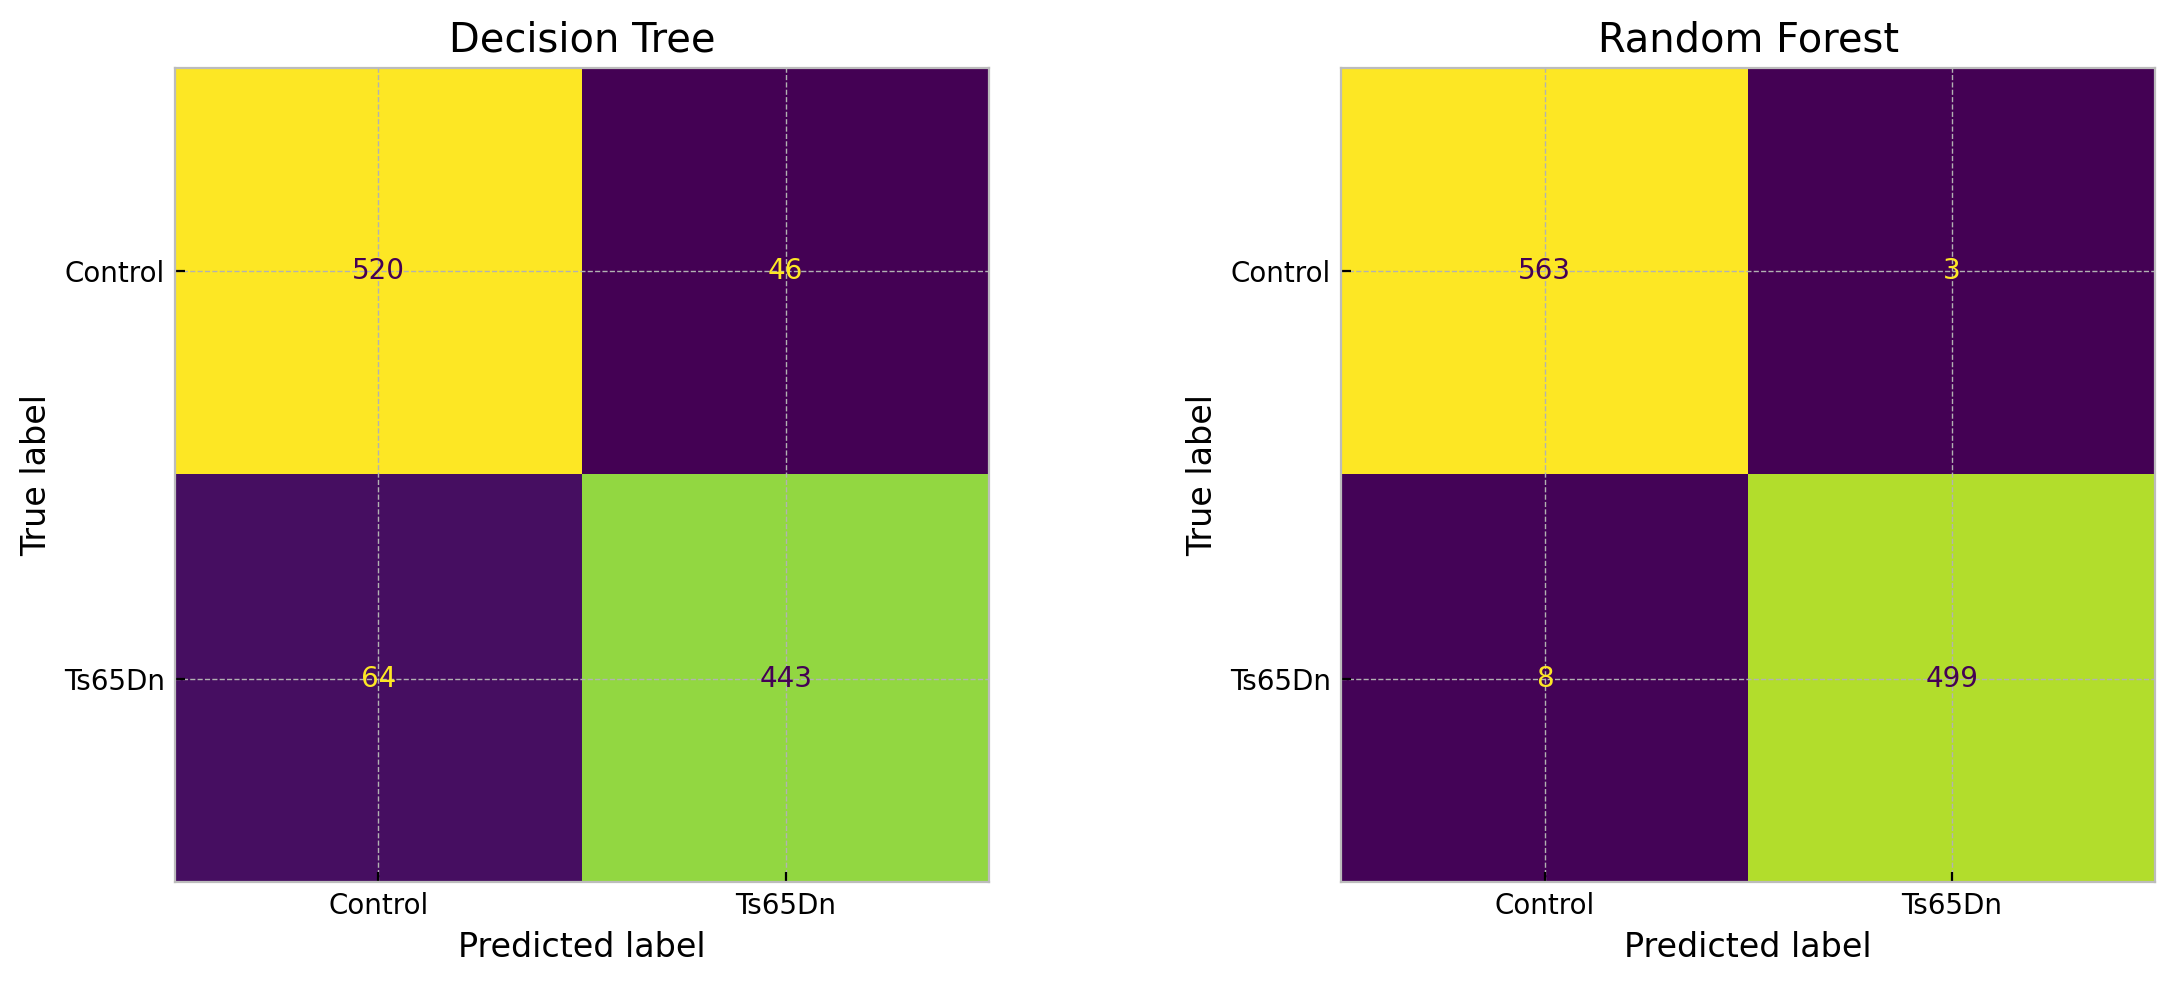

In [74]:
dtree = DecisionTreeClassifier(random_state=0)
rforest = RandomForestClassifier(n_estimators=100, random_state=0)

models = [dtree, rforest]
model_names = ['Decision Tree', 'Random Forest']

plt.figure(figsize=[12,5])
for i, model in enumerate(models):
    y_pred = cross_val_predict(model, X, y, cv=10)
    
    ax = plt.subplot(1, len(models), i+1)
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot(ax=ax, colorbar=None)
    plt.title(model_names[i])

plt.tight_layout();

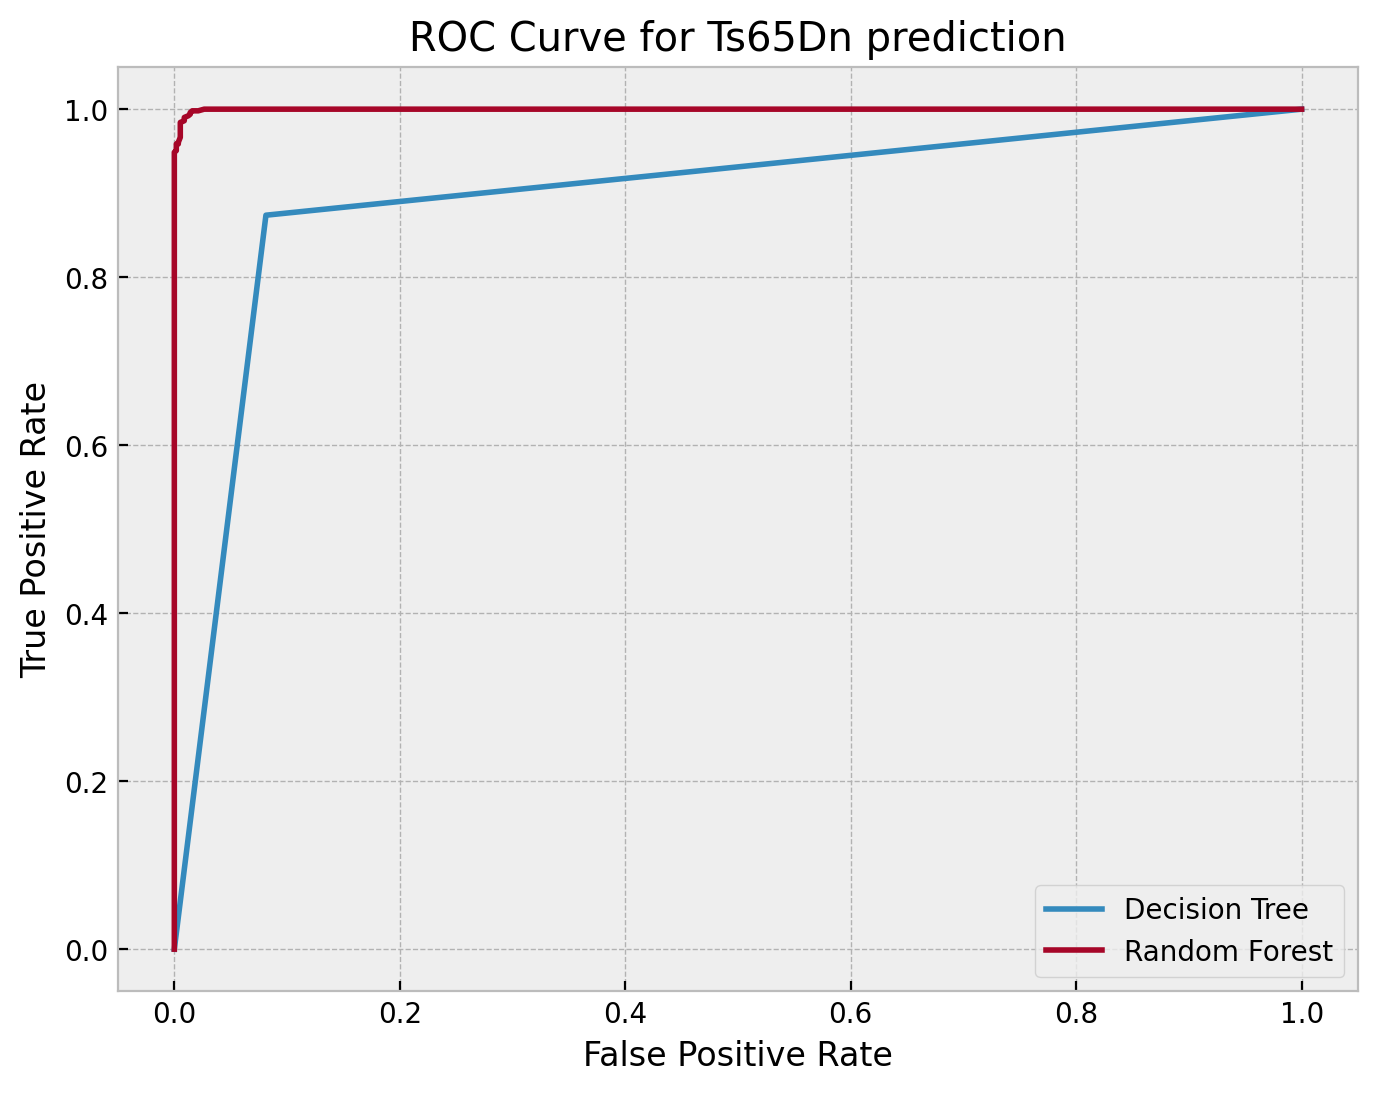

In [75]:
from sklearn.metrics import roc_curve

for i, model in enumerate(models):
    y_proba = cross_val_predict(model, X, y, cv=10, method='predict_proba')
    
    # ROC curve for the probability of classifying the genotype of each mouse as Ts65Dn
    class_labels = np.unique(y)
    fpr, tpr, thresholds = roc_curve(y, y_proba[:,1], pos_label=class_labels[1])
    plt.plot(fpr, tpr, label=model_names[i])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ' + class_labels[1] + ' prediction')
plt.legend();

# Exercise

Plot a confusion matrix for the ability of a random forest classifier with 100 trees to predict a mouse's class based on its protein expression profile.

In [ ]:
X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()
y = df2['class'].to_numpy()

X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69),
 (1073,),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

In [ ]:
# random forest classifier
model = ...

# cross validated predictions
y_pred = ...

# confusion matrix
cm = ...
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot();

# Exercise Key

Plot a confusion matrix for the ability of a random forest classifier with 100 trees to predict a mouse's class based on its protein expression profile.

In [76]:
X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()
y = df2['class'].to_numpy()

X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69),
 (1073,),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

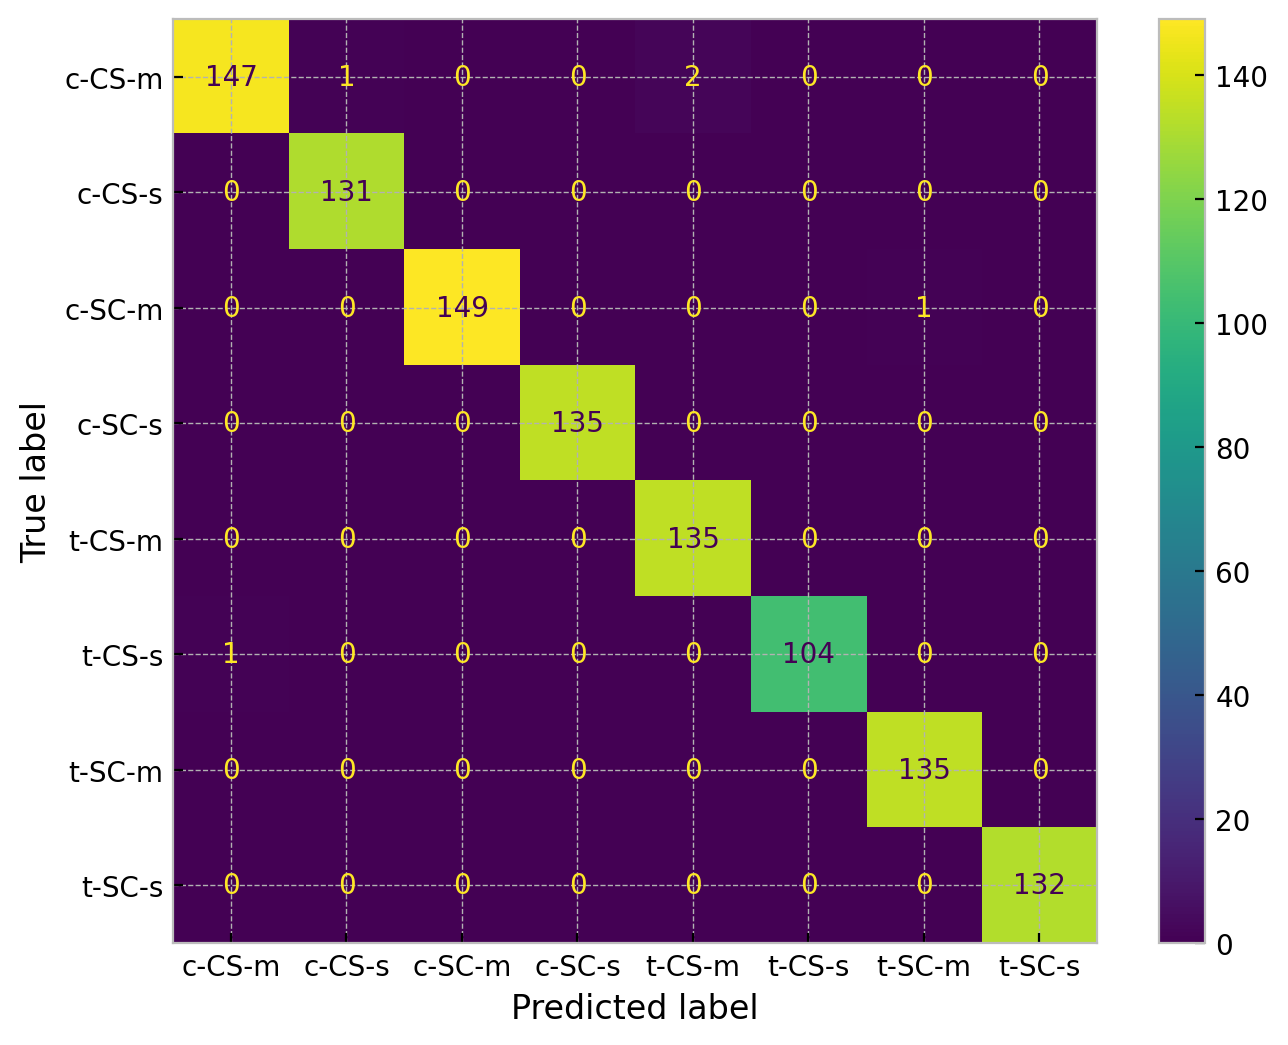

In [77]:
# random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=0)

# cross validated predictions
y_pred = cross_val_predict(model, X, y, cv=10)

# confusion matrix
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot();

# Question

How should you determine how many trees to have in your random forest classifier?

Together with `max_depth` what other hyperparameters might be important for a random forest classsifier?

In [78]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(random_state=0)
params = {
    'n_estimators':np.arange(50, 301, 25),
    'max_features':np.arange(0.1, 1, 0.1),
    'max_depth': np.arange(3, 20),
    'max_samples': [0.3, 0.5, 0.8, 1.0]
}
search = RandomizedSearchCV(model, params, cv=10, scoring='accuracy')
search.fit(X, y)

tuned_model = search.best_estimator_
tuned_model

RandomForestClassifier(max_depth=12, max_features=0.30000000000000004,
                       max_samples=0.5, n_estimators=300, random_state=0)

In [80]:
search.best_params_

{'n_estimators': 300,
 'max_samples': 0.5,
 'max_features': 0.30000000000000004,
 'max_depth': 12}

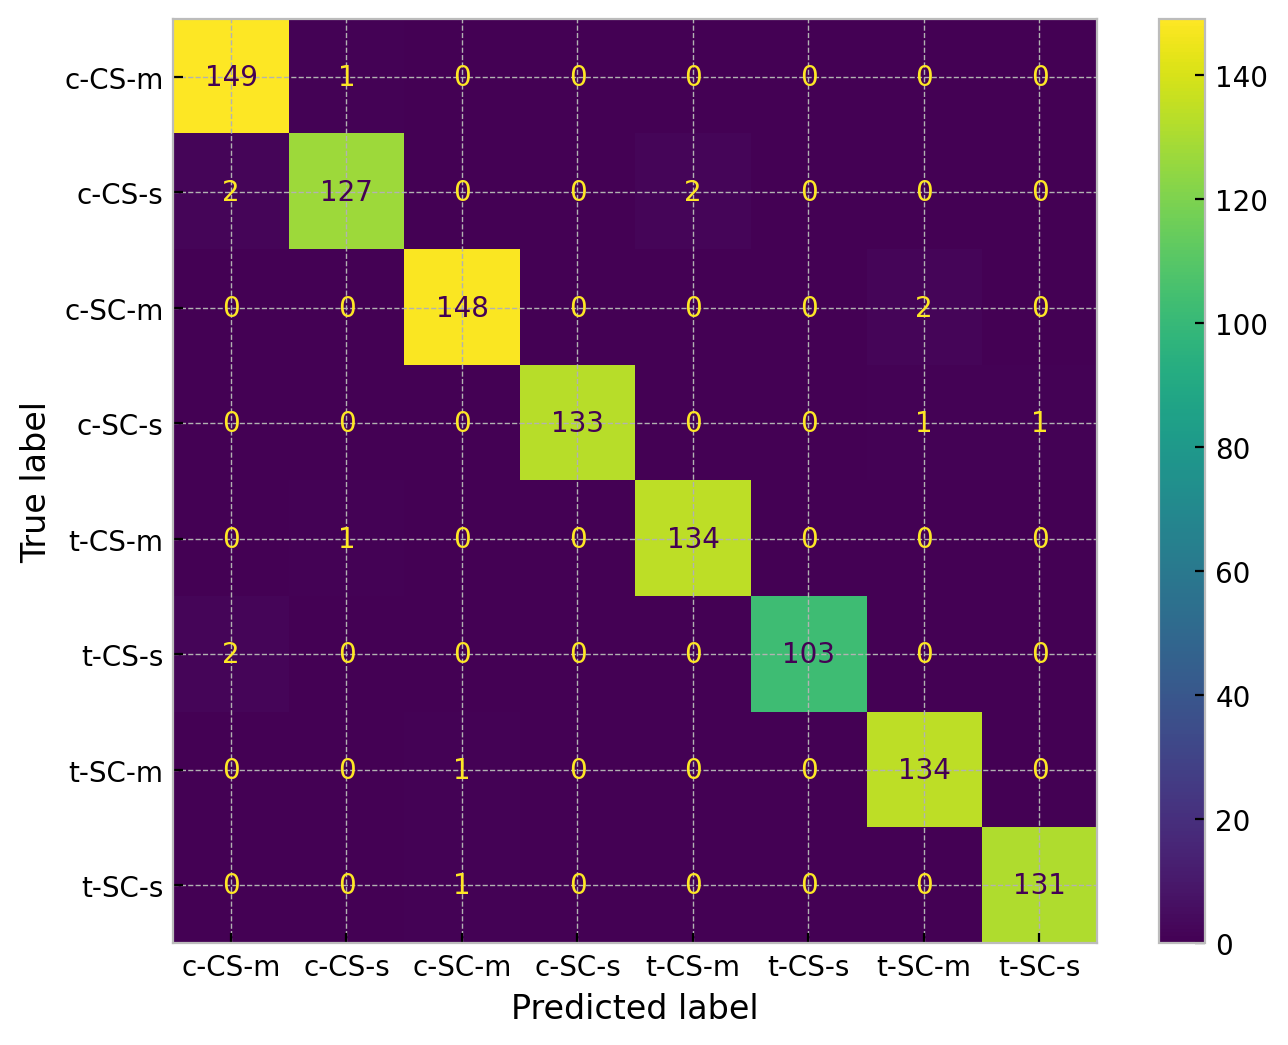

In [81]:
y_pred = cross_val_predict(tuned_model, X, y, cv=10)
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y)).plot();

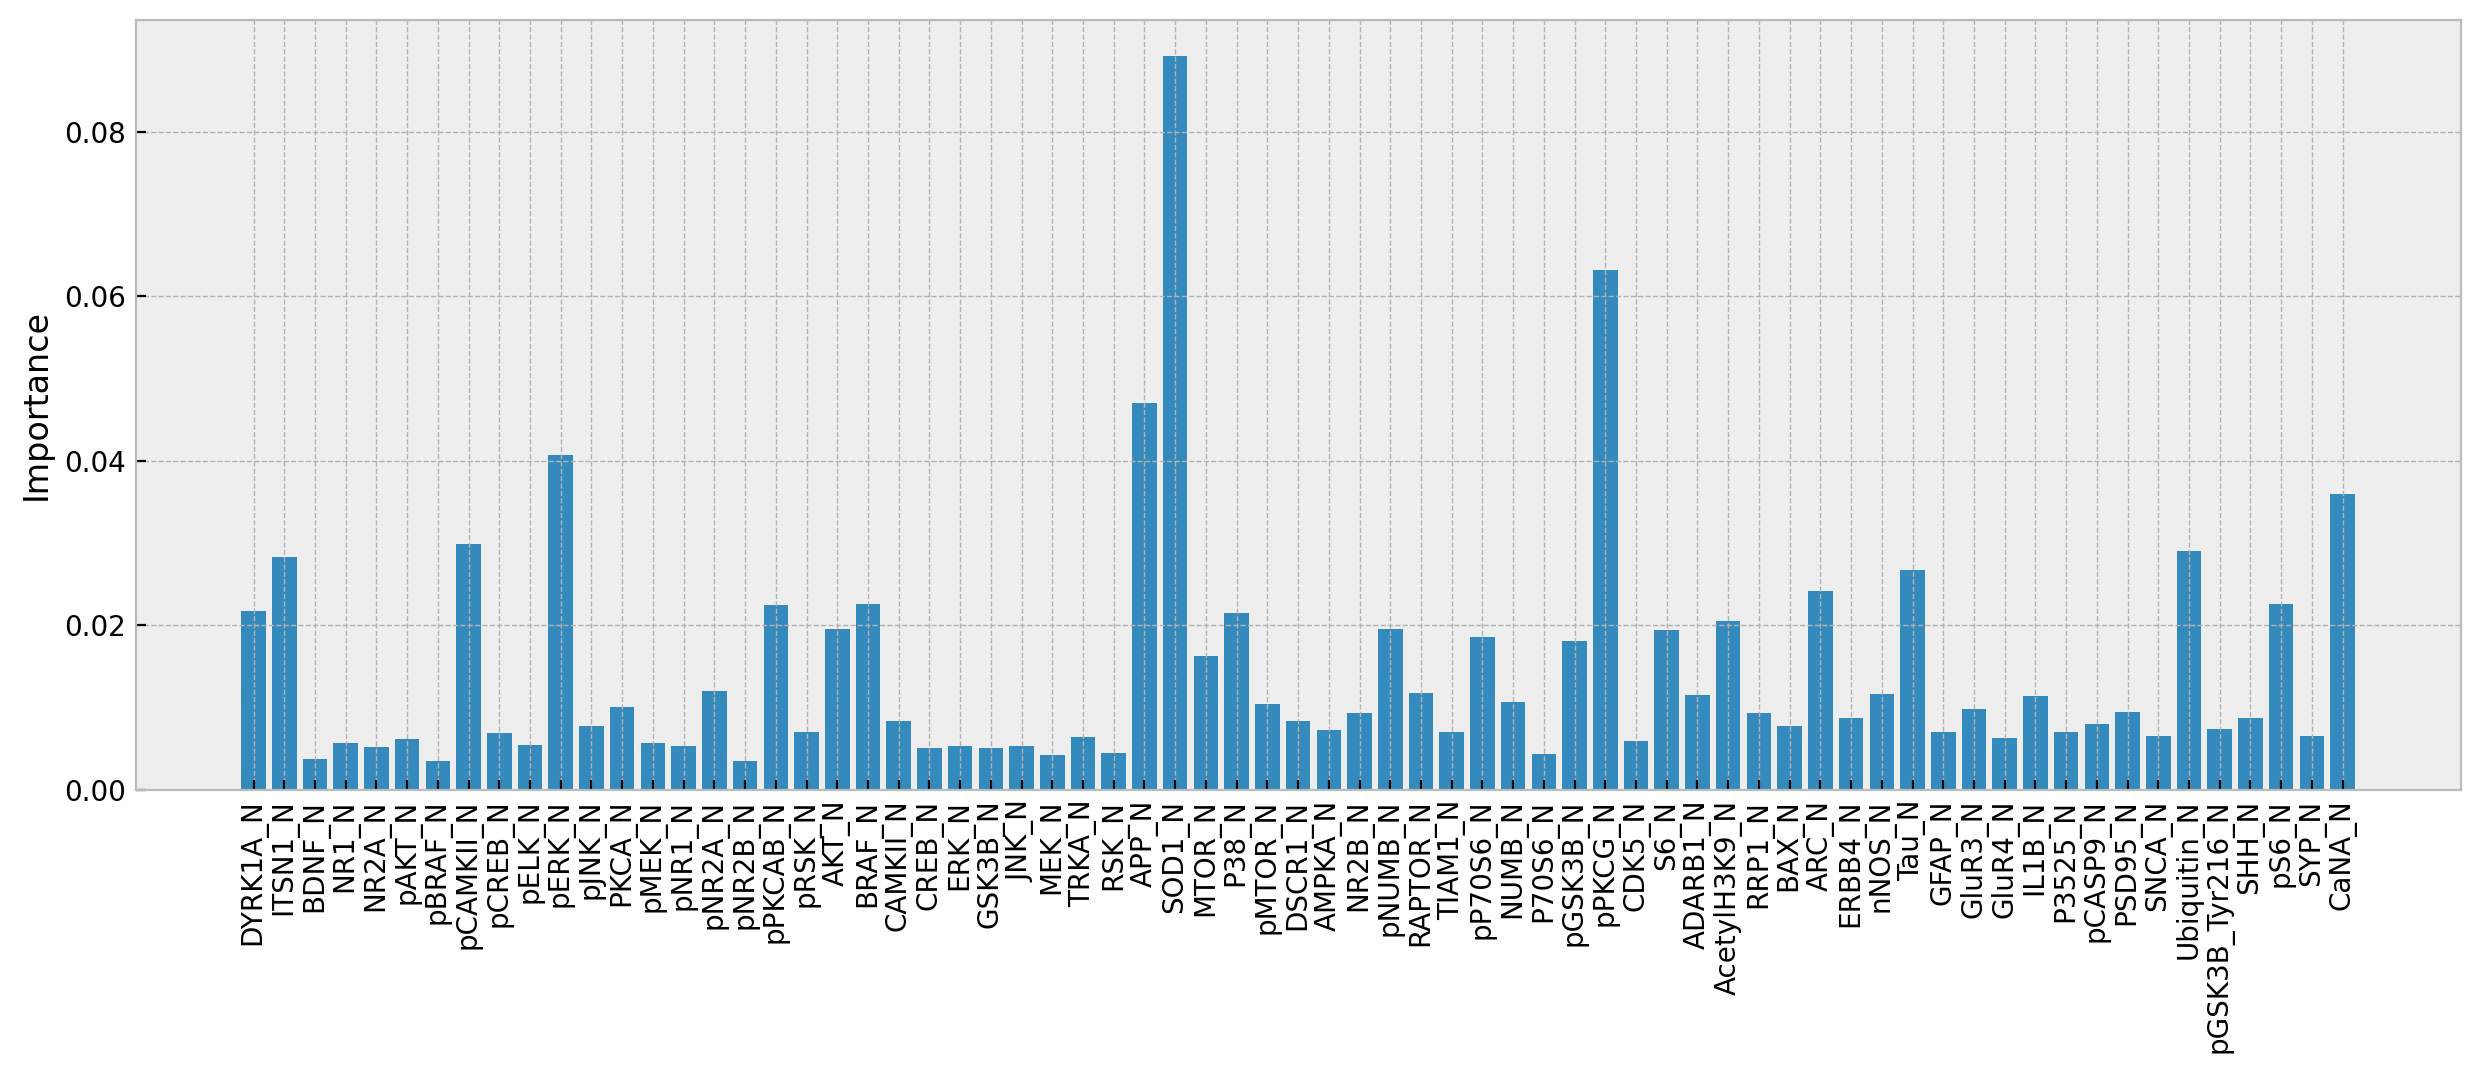

In [84]:
tuned_model.fit(X, y)

proteins = df2.loc[:,'DYRK1A_N':'CaNA_N'].columns

plt.figure(figsize=[15,5])
plt.bar(range(69), tuned_model.feature_importances_)
plt.xticks(range(69), proteins, rotation=90)
plt.ylabel('Importance');

# Boosting

### e.g., XGBoost classifier

### Learning goals - *XGBoost classifier*
|  |  |  |
|--|--|--|
| <img src="images/thinking-icon.png"> | <div class="alert alert-info">You will...</div> | `e.g.` |

## XGBoost

eXtreme Gradient Boosting

`conda install -c conda-forge xgboost`

### Gradient Boosting

![](images/gradient-boosting-error.png)

![](images/gradient-boost-example.png)

![](images/gradient-boosting-performance.png)

Bagging vs. Boosting

![](images/bagging-vs-boosting.png)

Use XGBoost to predict mouse class based on coritcal protein expression.

In [10]:
from sklearn.utils import shuffle

X = df2.loc[:,'DYRK1A_N':'CaNA_N'].to_numpy()
y = df2['class'].to_numpy()

X, y = shuffle(X, y, random_state=0)

X.shape, y.shape, np.unique(y)

((1073, 69),
 (1073,),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

model = XGBClassifier(n_estimators=100)

accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
accuracy.mean()

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/neu365p/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/neu365p/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/neu365p/lib/python3.11/site-packages/xgboost/sklearn.py", line 1440, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7], got ['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']


`xgboost` does not like string labels, so you'll need to convert your class string labels into integer labels.

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
yint = le.fit_transform(y)

y, yint

(array(['t-CS-s', 'c-SC-m', 'c-SC-s', ..., 't-SC-m', 'c-SC-s', 't-CS-m'],
       dtype=object),
 array([5, 2, 3, ..., 6, 3, 4]))

In [12]:
ylabels = le.inverse_transform(np.unique(yint))

np.unique(yint), ylabels

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array(['c-CS-m', 'c-CS-s', 'c-SC-m', 'c-SC-s', 't-CS-m', 't-CS-s',
        't-SC-m', 't-SC-s'], dtype=object))

In [16]:
model = XGBClassifier(n_estimators=100)

accuracy = cross_val_score(model, X, yint, cv=10, scoring='accuracy')
accuracy.mean()

0.9813603322949117

# Label Encoding

![](images/label-encoding.png)

Similar to random forest, this is a definite improvement right off the bat from a single decision tree.

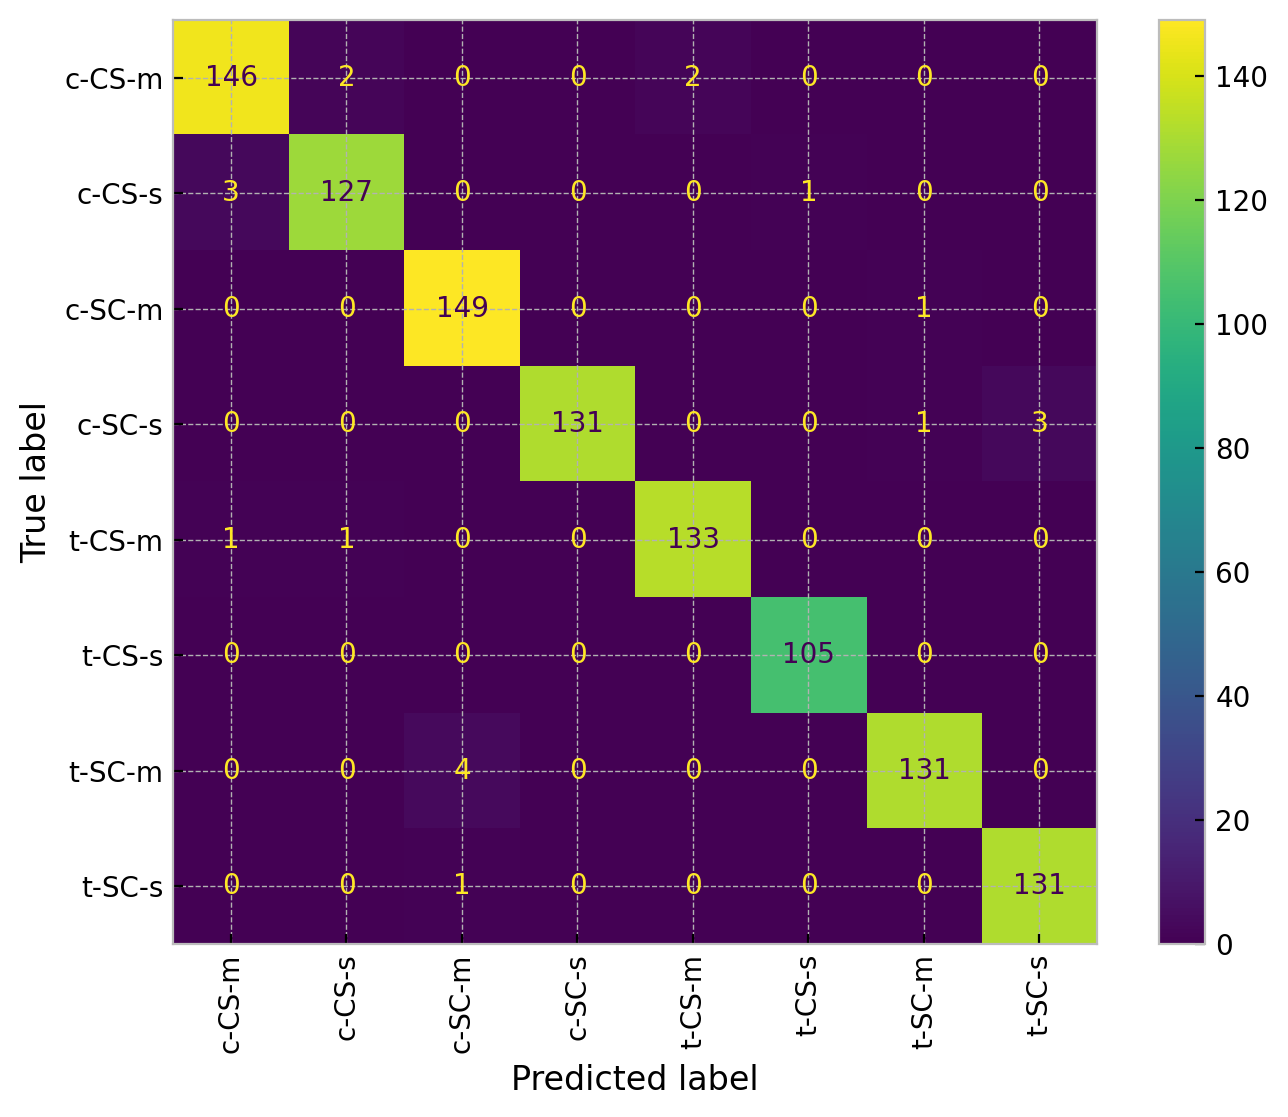

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = cross_val_predict(model, X, yint, cv=10)

cm = confusion_matrix(yint, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ylabels).plot(xticks_rotation='vertical');

Tune a few hyperparameters.

In [20]:
from sklearn.model_selection import RandomizedSearchCV

model = XGBClassifier()
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': np.arange(0.05, 0.25, 0.05),
    'max_depth': np.arange(2, 5),
    'gamma': np.arange(0.001, 0.012, 0.002),
    'lambda': np.logspace(-5, -3, 20),
    'alpha': np.arange(0.1, 2, 0.1)
}
search = RandomizedSearchCV(model, params, cv=10, scoring='accuracy')
search.fit(X, yint)
tuned_model = search.best_estimator_
search.best_params_, tuned_model

({'n_estimators': 300,
  'max_depth': 2,
  'learning_rate': 0.15000000000000002,
  'lambda': 2.6366508987303556e-05,
  'gamma': 0.007,
  'alpha': 0.8},
 XGBClassifier(alpha=0.8, base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.007, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, lambda=2.6366508987303556e-05,
               learning_rate=0.15000000000000002, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=300, n_jobs=None, num_parallel_tree=None, ...))

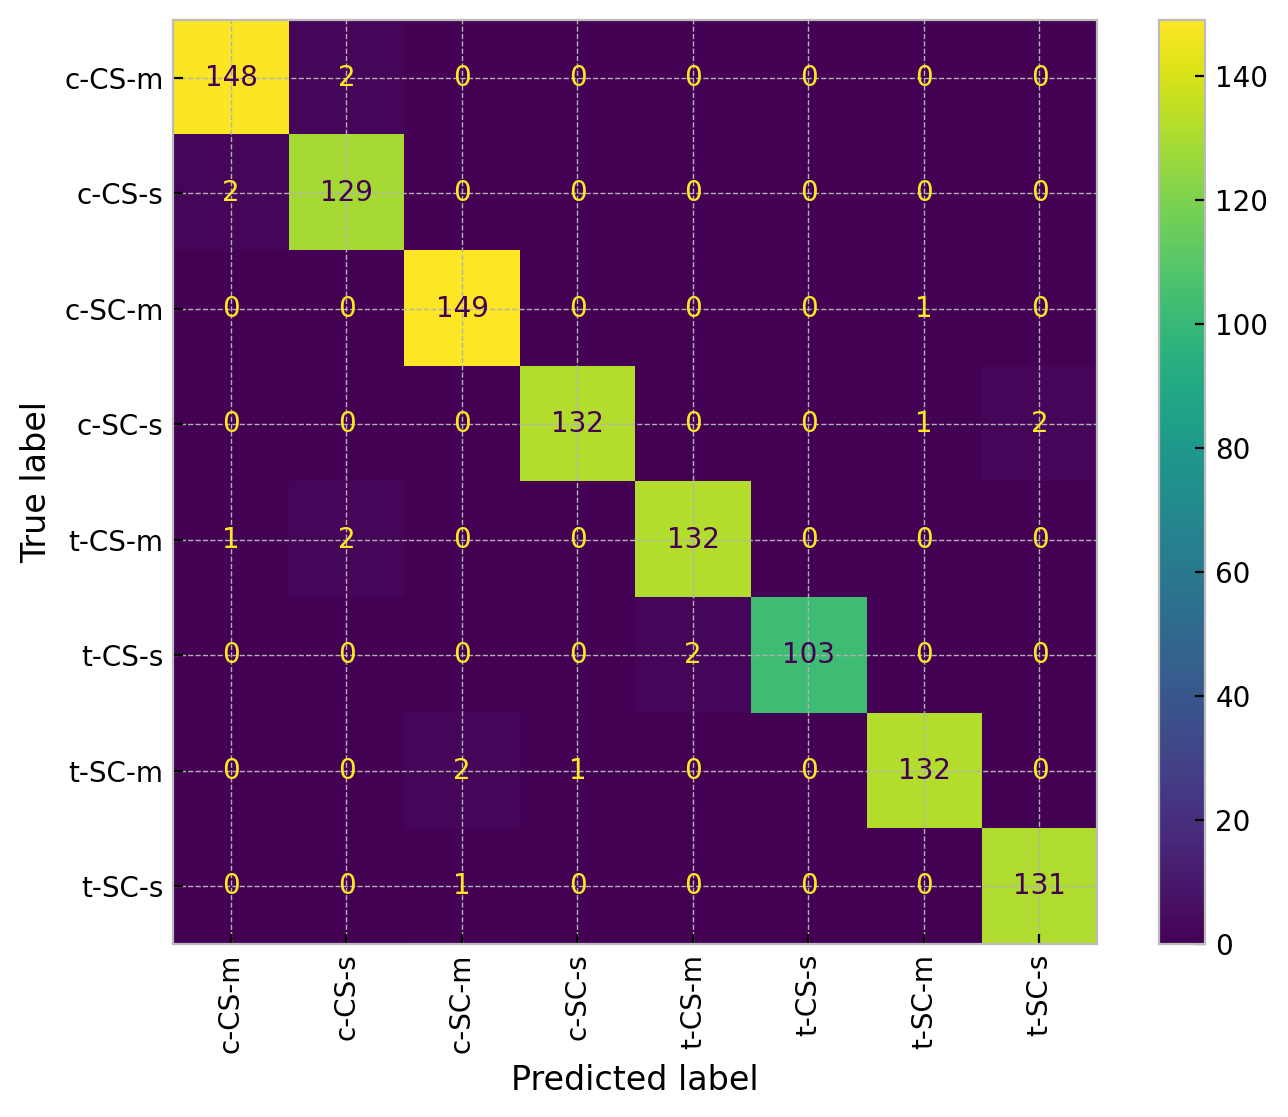

In [21]:
y_pred = cross_val_predict(tuned_model, X, yint, cv=10)

cm = confusion_matrix(yint, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ylabels).plot(xticks_rotation='vertical');

Tuning the hyperparameters maybe helped, but only slightly at most.

Perhaps other hyperparameters might be important?

# One-Hot Encoding

![](images/one-hot-encoding.png)

One-Hot encoding with `sklearn`.

In [43]:
df2[['Genotype']]

,Genotype
0,Control
1,Control
2,Control
3,Control
4,Control
...,...
1075,Ts65Dn
1076,Ts65Dn
1077,Ts65Dn
1078,Ts65Dn


In [37]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
genotype_one_hot = ohe.fit_transform(df2[['Genotype']])

genotype_one_hot.shape, genotype_one_hot

((1073, 2),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]]))

In [41]:
df_one_hot = df2[['Genotype']].copy()
df_one_hot['Control'] = genotype_one_hot[:,0]
df_one_hot['Ts65Dn'] = genotype_one_hot[:,1]
df_one_hot

,Genotype,Control,Ts65Dn
0,Control,1.0,0.0
1,Control,1.0,0.0
2,Control,1.0,0.0
3,Control,1.0,0.0
4,Control,1.0,0.0
...,...,...,...
1075,Ts65Dn,0.0,1.0
1076,Ts65Dn,0.0,1.0
1077,Ts65Dn,0.0,1.0
1078,Ts65Dn,0.0,1.0


Compare with label encoding.

In [46]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
genotype_label_encoded = le.fit_transform(df2['Genotype'])

genotype_label_encoded.shape, genotype_label_encoded

((1073,), array([0, 0, 0, ..., 1, 1, 1]))

In [47]:
df_label_encoded = df2[['Genotype']].copy()
df_label_encoded['labels'] = genotype_label_encoded
df_label_encoded

,Genotype,labels
0,Control,0
1,Control,0
2,Control,0
3,Control,0
4,Control,0
...,...,...
1075,Ts65Dn,1
1076,Ts65Dn,1
1077,Ts65Dn,1
1078,Ts65Dn,1


- Label encoding almost always used for target variable categories.
- One Hot encoding almost always used for feature variable categories.